In [242]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import seaborn as sns


In [243]:
features = pd.read_pickle("../train_features.pkl")
labels = pd.read_csv("../train_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features_original = features.join(labels)
features_original = features_original[~pd.isna(features_original["classALeRCE"])]

features_test = pd.read_pickle("../test_features.pkl")

In [244]:
dropped_objects = features_original[features_original["classALeRCE"].isin(["EB", "LPV","QSO", "RRL"])].sample(frac=0.9)
features = features_original.drop(dropped_objects.index)


In [264]:
#https://github.com/jrzaurin/LightGBM-with-Focal-Loss
import scipy
import scipy.misc
def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = scipy.misc.derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = scipy.misc.derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

In [326]:
import sklearn.preprocessing
import sklearn.model_selection


label_encoder = sklearn.preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(features["classALeRCE"])

#should split here into train and test!

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features.drop("classALeRCE", axis=1),
                                                                            encoded_labels,
                                                                            test_size=0.2, random_state=0)
train_dataset = lgb.Dataset(X_train, 
                            label=y_train,
                            free_raw_data=True
                           )

test_dataset = lgb.Dataset(X_test, 
                            label=y_test,
                            free_raw_data=True
                           )

In [337]:
params = {
    'num_leaves': 31,
    'objective': 'multiclass',
    'num_class':14,
    'num_iterations':500,
    'max_depth' : 30,
    'learning_rate' : 5e-3,
    'bagging_fraction' : 0.9,
    'feature_fraction' : 0.9,
    'early_stopping_round' : 10,
}

In [338]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 2., 14)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 2., 14)
model = lgb.train(params, train_dataset, valid_sets=[test_dataset], 
                  fobj=focal_loss,
                  feval=eval_error 
                 )

[1]	valid_0's focal_loss: 0.123028
Training until validation scores don't improve for 10 rounds
[2]	valid_0's focal_loss: 0.122286
[3]	valid_0's focal_loss: 0.121549
[4]	valid_0's focal_loss: 0.120816
[5]	valid_0's focal_loss: 0.120088
[6]	valid_0's focal_loss: 0.119366
[7]	valid_0's focal_loss: 0.118648
[8]	valid_0's focal_loss: 0.117937
[9]	valid_0's focal_loss: 0.117232
[10]	valid_0's focal_loss: 0.11653
[11]	valid_0's focal_loss: 0.115833
[12]	valid_0's focal_loss: 0.115142
[13]	valid_0's focal_loss: 0.114457
[14]	valid_0's focal_loss: 0.113775
[15]	valid_0's focal_loss: 0.113098
[16]	valid_0's focal_loss: 0.112426
[17]	valid_0's focal_loss: 0.111759
[18]	valid_0's focal_loss: 0.111096
[19]	valid_0's focal_loss: 0.110442
[20]	valid_0's focal_loss: 0.109789
[21]	valid_0's focal_loss: 0.10914
[22]	valid_0's focal_loss: 0.108496
[23]	valid_0's focal_loss: 0.107858
[24]	valid_0's focal_loss: 0.107225
[25]	valid_0's focal_loss: 0.106595
[26]	valid_0's focal_loss: 0.10597
[27]	valid_0's 

[220]	valid_0's focal_loss: 0.0384312
[221]	valid_0's focal_loss: 0.0382556
[222]	valid_0's focal_loss: 0.0380796
[223]	valid_0's focal_loss: 0.0379055
[224]	valid_0's focal_loss: 0.0377329
[225]	valid_0's focal_loss: 0.0375606
[226]	valid_0's focal_loss: 0.037389
[227]	valid_0's focal_loss: 0.0372185
[228]	valid_0's focal_loss: 0.0370501
[229]	valid_0's focal_loss: 0.0368814
[230]	valid_0's focal_loss: 0.036714
[231]	valid_0's focal_loss: 0.0365482
[232]	valid_0's focal_loss: 0.0363849
[233]	valid_0's focal_loss: 0.0362214
[234]	valid_0's focal_loss: 0.0360587
[235]	valid_0's focal_loss: 0.035896
[236]	valid_0's focal_loss: 0.0357354
[237]	valid_0's focal_loss: 0.0355756
[238]	valid_0's focal_loss: 0.0354173
[239]	valid_0's focal_loss: 0.0352589
[240]	valid_0's focal_loss: 0.0351019
[241]	valid_0's focal_loss: 0.0349459
[242]	valid_0's focal_loss: 0.0347911
[243]	valid_0's focal_loss: 0.0346369
[244]	valid_0's focal_loss: 0.0344833
[245]	valid_0's focal_loss: 0.0343311
[246]	valid_0's

[437]	valid_0's focal_loss: 0.0168031
[438]	valid_0's focal_loss: 0.0167533
[439]	valid_0's focal_loss: 0.0167031
[440]	valid_0's focal_loss: 0.0166541
[441]	valid_0's focal_loss: 0.0166045
[442]	valid_0's focal_loss: 0.0165552
[443]	valid_0's focal_loss: 0.0165061
[444]	valid_0's focal_loss: 0.0164569
[445]	valid_0's focal_loss: 0.0164091
[446]	valid_0's focal_loss: 0.0163604
[447]	valid_0's focal_loss: 0.0163126
[448]	valid_0's focal_loss: 0.0162653
[449]	valid_0's focal_loss: 0.0162175
[450]	valid_0's focal_loss: 0.0161704
[451]	valid_0's focal_loss: 0.0161238
[452]	valid_0's focal_loss: 0.0160774
[453]	valid_0's focal_loss: 0.016031
[454]	valid_0's focal_loss: 0.0159839
[455]	valid_0's focal_loss: 0.0159373
[456]	valid_0's focal_loss: 0.0158919
[457]	valid_0's focal_loss: 0.0158468
[458]	valid_0's focal_loss: 0.0158015
[459]	valid_0's focal_loss: 0.0157577
[460]	valid_0's focal_loss: 0.0157128
[461]	valid_0's focal_loss: 0.0156685
[462]	valid_0's focal_loss: 0.015625
[463]	valid_0'

In [358]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)
prediction = softmax(model.predict(features_test))


In [359]:
test_df = pd.DataFrame(prediction, columns=label_encoder.classes_)
test_df["challenge_oid"] = features_test.index
test_df["Outlier"] = 0.

In [360]:
test_df.to_csv("gb.csv",  index=False)

In [349]:
#CODE FROM https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    fmt = '.2f' if normalize else 'd'
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

array([ 1,  0,  5, ...,  1, 11,  6])

In [356]:
import sklearn.metrics
df_predict = softmax(model.predict(X_test))
cm = sklearn.metrics.confusion_matrix(y_test, 
                                      np.argmax(df_predict, axis=1),
                                      )

Normalized confusion matrix


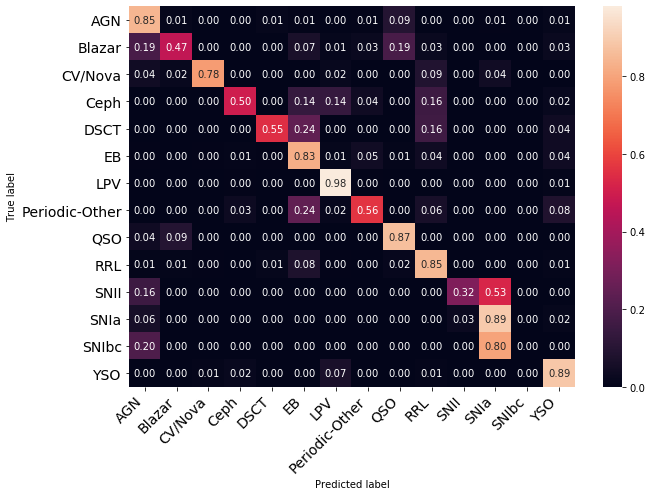

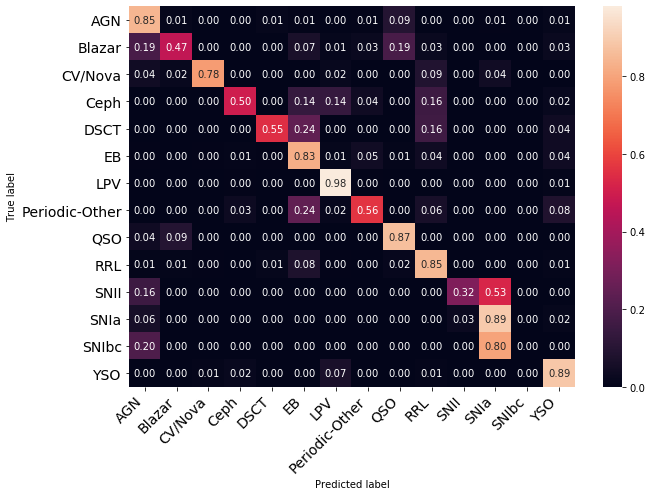

In [357]:
print_confusion_matrix(cm, label_encoder.classes_)